# AKARI-SEP - Merging HELP data products

This notebook merges the various HELP data products on AKARI-SEP.

It is first used to create a catalogue that will be used for SED fitting by CIGALE by merging the optical master list, the photo-z and the XID+ far infrared fluxes.  Then, this notebook is used to incorporate the CIGALE physical parameter estimations and generate the final HELP data product on the field.

In [1]:
# Set this to true to produce only the catalogue for CIGALE and to false 
# to continue and merge the CIGALE results too.
MAKE_CIGALE_INPUT = True
MAKE_FINAL_CAT = False

SUFFIX = '20210702'

In [2]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

from astropy.table import Column, MaskedColumn, Table, join, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u

from herschelhelp.filters import get_filter_meta_table

from herschelhelp_internal.utils import add_column_meta
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
filter_mean_lambda = {
    item['filter_id']: item['mean_wavelength'] for item in
    get_filter_meta_table()
}

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam wa

# Reading the masterlist, XID+, and photo-z catalogues

In [3]:
# Master list

ml = Table.read(
    "../../dmu1/dmu1_ml_AKARI-SEP/data/master_catalogue_akari-sep_dr2_{}.fits".format(SUFFIX))
ml.meta = None

In [4]:
old_ml=Table.read(
    "../../dmu1/dmu1_ml_AKARI-SEP/data/master_catalogue_akari-sep_20180221.fits")['ra','dec','help_id']
old_ml['ra'].name='ra_dr1'
old_ml['dec'].name='dec_dr1'
old_ml['help_id'].name='help_id_dr1'

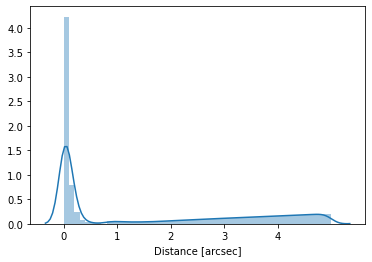

In [5]:
nb_merge_dist_plot(
    SkyCoord(ml['ra'], ml['dec']),
    SkyCoord(old_ml['ra_dr1'], old_ml['dec_dr1'])
)

In [6]:
# Given the graph above, we use 0.8 arc-second radius
ml = merge_catalogues(ml, old_ml, "ra_dr1", "dec_dr1", radius=0.4*u.arcsec)

In [7]:
# # XID+ MIPS24

xid_mips24 = Table.read("../../dmu26/dmu26_XID+MIPS_AKARI-SEP/data/"
                          "dmu26_XID+MIPS_AKARI-SEP_cat_20190909.fits")
xid_mips24.meta = None

# Adding the error column
xid_mips24.add_column(Column(
    data=np.max([xid_mips24['FErr_MIPS_24_u'] - xid_mips24['F_MIPS_24'],
                 xid_mips24['F_MIPS_24'] - xid_mips24['FErr_MIPS_24_l']],
                axis=0),
    name="ferr_mips_24"
))
xid_mips24['F_MIPS_24'].name = "f_mips_24"
xid_mips24 = xid_mips24['help_id', 'f_mips_24', 'ferr_mips_24', 'flag_mips_24']

xid_mips24['help_id'].name='help_id_dr1'

In [8]:
# XID+ PACS

xid_pacs = Table.read("../../dmu26/dmu26_XID+PACS_AKARI-SEP/data/"
                        "dmu26_XID+PACS_AKARI-SEP_cat_20190924.fits")
xid_pacs.meta = None

# Convert from mJy to μJy
for col in ["F_PACS_100", "FErr_PACS_100_u", "FErr_PACS_100_l",
            "F_PACS_160", "FErr_PACS_160_u", "FErr_PACS_160_l"]:
    xid_pacs[col] *= 1000

xid_pacs.add_column(Column(
    data=np.max([xid_pacs['FErr_PACS_100_u'] - xid_pacs['F_PACS_100'],
                 xid_pacs['F_PACS_100'] - xid_pacs['FErr_PACS_100_l']],
                axis=0),
   name="ferr_pacs_green"
))
xid_pacs['F_PACS_100'].name = "f_pacs_green"
xid_pacs['flag_PACS_100'].name = "flag_pacs_green"

xid_pacs.add_column(Column(
    data=np.max([xid_pacs['FErr_PACS_160_u'] - xid_pacs['F_PACS_160'],
                 xid_pacs['F_PACS_160'] - xid_pacs['FErr_PACS_160_l']],
                axis=0),
    name="ferr_pacs_red"
))
xid_pacs['F_PACS_160'].name = "f_pacs_red"
xid_pacs['flag_PACS_160'].name = "flag_pacs_red"

xid_pacs = xid_pacs['help_id', 'f_pacs_green', 'ferr_pacs_green',
                    'flag_pacs_green', 'f_pacs_red', 'ferr_pacs_red',
                    'flag_pacs_red']

xid_pacs['help_id'].name='help_id_dr1'

In [9]:
# # XID+ SPIRE

xid_spire = Table.read("../../dmu26/dmu26_XID+SPIRE_AKARI-SEP/data/"
                         "dmu26_XID+SPIRE_AKARI-SEP_cat_20190916.fits")
xid_spire.meta = None

xid_spire['HELP_ID'].name = "help_id"

# Convert from mJy to μJy
for col in ["F_SPIRE_250", "FErr_SPIRE_250_u", "FErr_SPIRE_250_l",
            "F_SPIRE_350", "FErr_SPIRE_350_u", "FErr_SPIRE_350_l",
            "F_SPIRE_500", "FErr_SPIRE_500_u", "FErr_SPIRE_500_l"]:
    xid_spire[col] *= 1000

xid_spire.add_column(Column(
    data=np.max([xid_spire['FErr_SPIRE_250_u'] - xid_spire['F_SPIRE_250'],
                 xid_spire['F_SPIRE_250'] - xid_spire['FErr_SPIRE_250_l']],
                axis=0),
    name="ferr_spire_250"
))
xid_spire['F_SPIRE_250'].name = "f_spire_250"
xid_spire.add_column(Column(
    data=np.max([xid_spire['FErr_SPIRE_350_u'] - xid_spire['F_SPIRE_350'],
                 xid_spire['F_SPIRE_350'] - xid_spire['FErr_SPIRE_350_l']],
                axis=0),
    name="ferr_spire_350"
))
xid_spire['F_SPIRE_350'].name = "f_spire_350"
xid_spire.add_column(Column(
    data=np.max([xid_spire['FErr_SPIRE_500_u'] - xid_spire['F_SPIRE_500'],
                 xid_spire['F_SPIRE_500'] - xid_spire['FErr_SPIRE_500_l']],
                axis=0),
    name="ferr_spire_500"
))
xid_spire['F_SPIRE_500'].name = "f_spire_500"

xid_spire = xid_spire['help_id',
                      'f_spire_250', 'ferr_spire_250', 'flag_spire_250',
                      'f_spire_350', 'ferr_spire_350', 'flag_spire_350',
                      'f_spire_500', 'ferr_spire_500', 'flag_spire_500']
xid_spire['help_id'].name='help_id_dr1'

In [10]:
# Photo-z

photoz = Table.read("../../dmu24/dmu24_AKARI-SEP/data/AKARI-SEP_DESI-DR8_Zou_et_al_2019_photo_z_withhelp_id.fits")
photoz.meta = None

photoz = photoz['help_id', 'photo_z']
photoz['photo_z'].name = 'redshift'

photoz['redshift'][photoz['redshift'] < 0] = np.nan  # -99 used for missing values
photoz['help_id'].name='help_id_dr1'

In [11]:
# Temp spec-z



ml['zspec'][ml['zspec'] < 0] = np.nan  # -99 used for missing values

In [12]:
# Flags
flags = Table.read("../../dmu6/dmu6_v_AKARI-SEP/data/akari-sep_20180221_flags.fits")
flags['help_id'].name='help_id_dr1'

# Merging

In [13]:
ml=ml[~ml['help_id_dr1'].mask]

In [14]:
merged_table = join(ml, xid_mips24, join_type='left')

# Fill values
for col in xid_mips24.colnames:
    if col.startswith("f_") or col.startswith("ferr_"):
        merged_table[col].fill_value = np.nan
    elif col.startswith("flag_"):
        merged_table[col].fill_value = False
merged_table = merged_table.filled()

In [15]:
merged_table = join(merged_table, xid_pacs, join_type='left')
        
# Fill values
for col in xid_pacs.colnames:
    if col.startswith("f_") or col.startswith("ferr_"):
        merged_table[col].fill_value = np.nan
    elif col.startswith("flag_"):
        merged_table[col].fill_value = False
merged_table = merged_table.filled()

In [16]:
merged_table = join(merged_table, xid_spire, join_type='left')
        
# Fill values
for col in xid_spire.colnames:
    if col.startswith("f_") or col.startswith("ferr_"):
        merged_table[col].fill_value = np.nan
    elif col.startswith("flag_"):
        merged_table[col].fill_value = False
merged_table = merged_table.filled()

In [17]:
merged_table = join(merged_table, photoz, join_type='left')

# Fill values
merged_table['redshift'].fill_value = np.nan
merged_table = merged_table.filled()

In [18]:
for col in flags.colnames:
    if 'flag' in col:
        try:
            merged_table.remove_column(col)
        except KeyError:
            print("Column: {} not in masterlist.".format(col))
        
merged_table = join(merged_table, flags, join_type='left')
# Fill values
for col in merged_table.colnames:
    if 'flag' in col:
        merged_table[col].fill_value = False
merged_table = merged_table.filled()

# Saving the catalogue for CIGALE (first run)

In [22]:
for c in merged_table.colnames:
    for inst in ['galex','ctio','wfi','vst','wise','akari']:
        if inst in c:
            merged_table.remove_columns(c)

In [27]:
if MAKE_CIGALE_INPUT:
    
    # Sorting the columns
    bands_tot = [col[2:] for col in merged_table.colnames
             if col.startswith('f_') and not col.startswith('f_ap')]
    bands_ap = [col[5:] for col in merged_table.colnames
             if col.startswith('f_ap_') ]
    bands = list(set(bands_tot) | set(bands_ap))
    bands.sort(key=lambda x: filter_mean_lambda[x])
    
    columns = ['help_id', 'field', 'ra', 'dec', 'hp_idx', 'ebv', 'redshift', 
               'zspec']
    for band in bands:
        for col_tpl in ['f_{}', 'ferr_{}', 'f_ap_{}', 'ferr_ap_{}',
                        'm_{}', 'merr_{}', 'm_ap_{}', 'merr_ap_{}',
                        'flag_{}']:
            colname = col_tpl.format(band)
            if colname in merged_table.colnames:
                columns.append(colname)
    columns += ['stellarity', 'stellarity_origin', 'flag_cleaned',
                'flag_merged', 'flag_gaia', 'flag_optnir_obs',
                'flag_optnir_det', 'zspec_qual', 'zspec_association_flag','help_id_dr1']
    

    # Check that we did not forget any column
    print(set(columns) - set(merged_table.colnames))
    print( set(merged_table.colnames) - set(columns) )
    
    merged_table = add_column_meta(merged_table, '../columns.yml')
    merged_table[columns].write("data/AKARI-SEP_{}_cigale.fits".format(SUFFIX), overwrite=True)

set()
set()
Column help_id_dr1 has missing data


# Merging CIGALE outputs

We merge the CIGALE outputs to the main catalogue. The CIGALE products provides several χ² with associated thresholds. For simplicity, we convert these two values to flags.

In [36]:
if MAKE_FINAL_CAT:

    # Cigale outputs
    cigale = Table.read("../../dmu28/dmu28_AKARI-SEP/data/zphot/HELP_final_results.fits")
    cigale['id'].name = "help_id"
    
    #remove duplicates - this problem will be fixed upstream in dmu2 merging but this is a quick hack
    cigale.sort('help_id')
    is_duplicate = cigale['help_id'][1:] == cigale['help_id'][:-1]
    if np.sum(is_duplicate)>0:
        print('Field has CIGALE duplicates... removing them!')
    cigale = cigale[~np.append(is_duplicate,False)]

    # We convert the various Chi2 and threshold to flags
    # UPDATE - we no longer do this and instead provide the chi2 values 
    #flag_cigale_opt = cigale["UVoptIR_OPTchi2"] <= cigale["UVoptIR_OPTchi2_threshold"]
    #flag_cigale_ir = cigale["UVoptIR_IRchi2"] <= cigale["UVoptIR_IRchi2_threshold"]
    #flag_cigale = (
    #    (cigale["UVoptIR_best.reduced_chi_square"] 
    #         <=  cigale["UVoptIR_best.reduced_chi_square_threshold"]) &
    #    flag_cigale_opt & flag_cigale_ir)
    #flag_cigale_ironly = cigale["IRonly_IRchi2"] <= cigale["IRonly_IRchi2_threshold"]

    #cigale.add_columns([
    #    MaskedColumn(flag_cigale, "flag_cigale", 
    #                 dtype=int, fill_value=-1),
    #    MaskedColumn(flag_cigale_opt, "flag_cigale_opt", 
    #                 dtype=int, fill_value=-1),
    #    MaskedColumn(flag_cigale_ir, "flag_cigale_ir", 
    #                 dtype=int, fill_value=-1),
    #    MaskedColumn(flag_cigale_ironly, "flag_cigale_ironly", 
    #                 dtype=int, fill_value=-1)
    #])
    
    #UPDATE Instead of flags above we include all cols used to make 
    #deprecated flags
    cigale["UVoptIR_OPTchi2"].name                 =  "cigale_chi2_opt"
    cigale["UVoptIR_IRchi2"].name                  =  "cigale_chi2_ir"
    cigale["UVoptIR_best.reduced_chi_square"].name =  "cigale_chi2_red"
    cigale["IRonly_IRchi2"].name                   =  "cigale_chi2_ironly"
    
    cigale['UVoptIR_bayes.stellar.m_star'].name =  "cigale_mstar"
    cigale['UVoptIR_bayes.stellar.m_star_err'].name = "cigale_mstar_err"
    cigale['UVoptIR_bayes.sfh.sfr10Myrs'].name = "cigale_sfr"
    cigale['UVoptIR_bayes.sfh.sfr10Myrs_err'].name = "cigale_sfr_err"
    cigale['UVoptIR_bayes.dust.luminosity'].name = "cigale_dustlumin"
    cigale['UVoptIR_bayes.dust.luminosity_err'].name = "cigale_dustlumin_err"
    cigale['IR_bayes.dust.luminosity'].name = "cigale_dustlumin_ironly"
    cigale['IR_bayes.dust.luminosity_err'].name = "cigale_dustlumin_ironly_err"

    cigale = cigale['help_id', 'cigale_mstar', 'cigale_mstar_err', 'cigale_sfr',
                    'cigale_sfr_err', 'cigale_dustlumin', 'cigale_dustlumin_err', 
                    'cigale_dustlumin_ironly', 'cigale_dustlumin_ironly_err', 
                    #Old flags
                    #'flag_cigale', 'flag_cigale_opt', 'flag_cigale_ir', 'flag_cigale_ironly'
                    #New chi2 values
                    "cigale_chi2_opt", "cigale_chi2_ir", "cigale_chi2_red", "cigale_chi2_ironly"
                   ]

In [37]:
if MAKE_FINAL_CAT:

    merged_table = join(merged_table, cigale, join_type='left')

    # Fill values
    for col in cigale.colnames:
        if col.startswith("cigale_"):
            merged_table[col].fill_value = np.nan
        elif col.startswith("flag_"):
            merged_table[col].fill_value = -1
    merged_table = merged_table.filled()

# Sorting columns

We sort the columns by increasing band wavelength.

In [38]:
if MAKE_FINAL_CAT:

    bands = [col[2:] for col in merged_table.colnames
             if col.startswith('f_') and not col.startswith('f_ap')]
    bands.sort(key=lambda x: filter_mean_lambda[x])

In [39]:
if MAKE_FINAL_CAT:

    columns = ['help_id', 'field', 'ra', 'dec', 'hp_idx', 'ebv', 'redshift', 'zspec']
    for band in bands:
        for col_tpl in ['f_{}', 'ferr_{}', 'f_ap_{}', 'ferr_ap_{}',
                        'm_{}', 'merr_{}', 'm_ap_{}', 'merr_ap_{}',
                        'flag_{}']:
            colname = col_tpl.format(band)
            if colname in merged_table.colnames:
                columns.append(colname)
    columns += ['cigale_mstar', 'cigale_mstar_err', 'cigale_sfr', 'cigale_sfr_err',
                'cigale_dustlumin', 'cigale_dustlumin_err', 'cigale_dustlumin_ironly', 
                'cigale_dustlumin_ironly_err', 
                #Old flags
                #'flag_cigale', 'flag_cigale_opt', 'flag_cigale_ir', 'flag_cigale_ironly'
                #New chi2 values
                'cigale_chi2_opt', 'cigale_chi2_ir', 'cigale_chi2_red', 'cigale_chi2_ironly',
                'stellarity', 
                'stellarity_origin', 'flag_cleaned', 'flag_merged', 'flag_gaia', 
                'flag_optnir_obs', 'flag_optnir_det', 'zspec_qual', 
                'zspec_association_flag']

In [40]:
if MAKE_FINAL_CAT:

    # Check that we did not forget any column
    assert set(columns) == set(merged_table.colnames)

# Saving

In [41]:
if MAKE_FINAL_CAT:

    merged_table = add_column_meta(merged_table, '../columns.yml')
    merged_table[columns].write("data/AKARI-SEP_{}.fits".format(SUFFIX), overwrite=True)

In [42]:
"data/AKARI-SEP_{}.fits".format(SUFFIX)

'data/AKARI-SEP_20210702.fits'